# Prepare data

In [202]:
import unidecode
import codecs
import string
import random
import re
import numpy as np

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(codecs.open('speeches.txt', "r",encoding='utf-8', errors='ignore').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 904663


In [203]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

'll say, "How can our politicians be so stupid?" They're not stupid. They're being hit by the lobbyists and the special interests and they make a fortune. Okay? They get tremendous campaign contributio


# Build the Model

In [204]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

In [205]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [206]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

In [207]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

In [208]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [209]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        #loss += criterion(output, target[c])
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    #return loss.data[0] / chunk_len
    return loss.data.item() / chunk_len

In [212]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 10s (100 5%) 2.2933]
Whatt has veand cne our neas mone pase we sem.




"Yc- go to. Nulingrer, poneret heu wneve seand 

 21s (200 10%) 2.1843]
Whe're go worll grettes arated gesling we's and a be ab sist peorss agill you you'y saillasis. The goi 

 34s (300 15%) 1.7062]
What that be whem our I be crouslies aas that is comnourton, 3on. we in whe or take intrend all bebode 

 46s (400 20%) 2.0487]
Whay the he jop in the bumive nual going the so world cant and to have spertion, nether is going to we 

 59s (500 25%) 2.0984]
What, whoo ou how some and wish and yobod yus. I to do bout of it our well one ofP there yever are Ima 

 12s (600 30%) 1.7681]
Where got. You right we our moung our jobbod, and have are them. And we pAle on for till pux that we'r 

 24s (700 35%) 2.2434]
Whing a verion actorer and have - be whe the wered and every the Smany that he's a for for many horlli 

 37s (800 40%) 1.8469]
Wh every $15 bit. I lot bumans aftered. It's the our rade money treapse, we we're don't

# Plotting the Training Losses

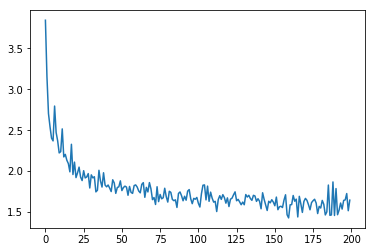

In [217]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In [214]:
print(evaluate('Th', 200, temperature=1.4))

Thousands ant.
And sit's she one 35 so gAin of kempuforina,ins somebrboosandorib when up..  Pads, brab in the vast incor..Pcwadpodirmef, let toesing..X;Himo,y Jencamizis anyYory, agotial.
I've the Anc


In [215]:
print(evaluate('Th', 200, temperature=0.8))

Thank it's can to get Pastion.
Think it make a prees incredisanted been Perice wreat? eally say soled a creaint things anything, if it.
I don't im and actua.
So here a lot jobs from going to get nest


In [216]:
print(evaluate('Th', 200, temperature=0.2))

Think your because the world we have and the world we have and the world we have the world we have the was and the world we're going to be and we have a lot of the world be the world we have the said "W


# Calculate Perplexity

In [ ]:
char_l = []
for i in all_characters:
    char_l += [i]

In [341]:
def next_char_prob(c, prime_str):
    temperature=0.2
    predict_len = 1
    
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    output, hidden = decoder(inp, hidden)
    output_dist = output.data.view(-1).div(temperature).exp()
    #output_dist = output.data.view(-1).exp()
    
    output_dist_l = output_dist.numpy()
    sum_score = sum(output_dist_l)
    
    c_score = output_dist_l[char_l.index(c)]
    
    return c_score/sum_score

In [342]:
def perplexity(sentence):
    N = len(sentence)
    
    score = 0 
    p_c1 = file.count(sentence[0])/len(file)
    score += np.log(p_c1)
    
    for i in range(1, N):
        curr_c = sentence[i]
        curr_prime = sentence[:i]
        curr_score = next_char_prob(curr_c, curr_prime)
        score += np.log(curr_score)
        
    return np.exp((-1)*(1/N)*(score))

In [357]:
ex1 = evaluate('Wh', 100, temperature=1.4)

In [358]:
print(ex1)

Wh', FHi8. It'se going Penksed P- the PHering care so cheae, in bild millions, if he's, I not bad. Vze


In [345]:
ex2 = evaluate('Wh', 100, temperature=0.2)

In [346]:
print(ex2)

Where we have the world what we have the said the world we have the world be the startion and the worl


In [359]:
perplexity(ex1)

593.1512534535195

In [348]:
perplexity(ex2)

1.391566849883651